# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mesa

In [ ]:
class Household(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        probabilities = np.array([0.66, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.01, 0.07, 0.01, 0.01, 0.01, 0.07])
        probabilities /= probabilities.sum()

        self.amount_of_solarpanels = np.random.choice(values, p=probabilities)
        self.consume_ph = np.random.randint(399, 513 + 1)
        self.produce_ph = self.amount_of_solarpanels * np.random.randint(300, 340 + 1)
        self.energy = 456
        self.money = 10
        self.price_per_Wh = 0.00024

    def trade_energy(self):
        self.energy += self.produce_ph
        self.energy -= self.consume_ph

        while True:
            possible_buyers = [agent for agent in self.model.agents if agent.energy < agent.consume_ph]
            surplus_energy = self.energy - self.consume_ph

            if surplus_energy > 0 and not possible_buyers:
                sell_to_gov = surplus_energy * self.price_per_Wh
                self.money += sell_to_gov
                self.energy -= surplus_energy
                break  

            if surplus_energy <= 0 or not possible_buyers:
                break

            possible_buyers.sort(key=lambda agent: agent.consume_ph - agent.energy, reverse=True)

            for other_household in possible_buyers:
                trade_amount = min(surplus_energy, other_household.consume_ph - other_household.energy)

                if trade_amount <= 0:
                    continue

                self.energy -= trade_amount
                other_household.energy += trade_amount
                surplus_energy -= trade_amount

                amount_owed = self.price_per_Wh * trade_amount

                if other_household.money >= amount_owed:
                    self.money += amount_owed
                    other_household.money -= amount_owed
                else:
                    affordable_trade = other_household.money / self.price_per_Wh
                    self.money += other_household.money
                    other_household.money = 0
                    trade_amount = affordable_trade
                    self.energy += (trade_amount - affordable_trade)

                if surplus_energy <= 0:
                    break

In [210]:
class Microgrid(mesa.Model):
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        Household.create_agents(model=self, n=n)

    def step(self):
        self.agents.shuffle_do("trade_energy")

In [211]:
sim = Microgrid(20)
sim.step()

In [212]:
sim = Microgrid(20)
for _ in range(24):
    sim.step()

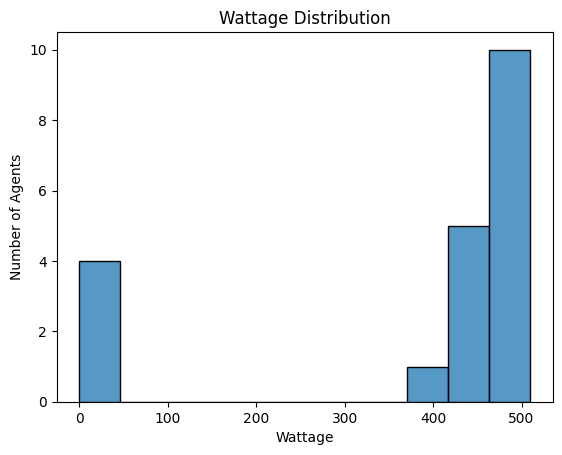

In [215]:
agent_wealth = [
    a.energy for a in sim.agents
]

g = sns.histplot(
    agent_wealth
)

g.set(
    title="Wattage Distribution", xlabel="Wattage", ylabel="Number of Agents"
);